# Projekt 1
Jakub Kozieł, Tomasz Krupiński, Jakub Lis

## Wczytanie pakietów i danych

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

In [2]:
census_df = pd.read_csv('census_income_dataset.csv')
census_df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_level
0,39,State-gov,77516.0,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419.0,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
48838,64,?,321403.0,HS-grad,9,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K
48839,38,Private,374983.0,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
48840,44,Private,83891.0,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K


Dla przypomnienia wyświetlimy jeszcze tabelę, co oznacza każda kolumna.

In [3]:
attributes_df = pd.read_csv('attributes_census_income.csv')

with pd.option_context('display.max_colwidth', 400):
    display(attributes_df)

,name,type,description
0,age,integer,age of individual
1,workclass,string,"Values: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked"
2,fnlwgt,float,Final sampling weight. Inverse of sampling fraction adjusted for non-response and over or under sampling of particular groups
3,education,string,"Values: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool"
4,education_num,integer,NaN
5,marital_status,string,"Values: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse"
6,occupation,string,"Values: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces"
7,relationship,string,"Values: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried"
8,race,string,"Values: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black"
9,sex,string,"Values: Female, Male"


## Inżynieria cech

### Wartości brakujące i kolumny redundantne

Bez zmian od drugiego kamienia milowego - usuwamy wiersze, które zawierają braki danych. Jest ich na tyle mało, że nie powinniśmy odczuć utratę takich danych.

In [4]:
census_df = census_df.replace(["?", -100000], np.nan)
census_df = census_df.dropna()

Także już przy pierwszym kamieniu milowym rozważaliśmy usuwanie kolumn, doszliśmy do wniosków, że kolumna "education" jest nadmiarowa (ponieważ posiadamy także education_num), a kolumna "fnlwgt" nie niesie szczególnego znaczenia dla dokonywania modelowania.

In [5]:
census_df = census_df.drop(columns = ["education","fnlwgt"])

### Kolumny "dwupunktowe"

W sposób zero-jedynkowy kodujemy kolumny, które zawierają tylko dwa rodzaje wartości.

In [6]:
census_df = census_df.replace("<=50K",0).replace(">50K",1)
census_df = census_df.replace("Male",1).replace("Female",0)

### Modyfikacja education_num

Podążając za otrzymaną wskazówką chcielibyśmy pogrupować dane z kolumny education_num i użyć OneHotEncoding. W tym celu przydatny będzie wykres pokazujący procent uzyskiwania wyższych zarobków dla danego "education_num".

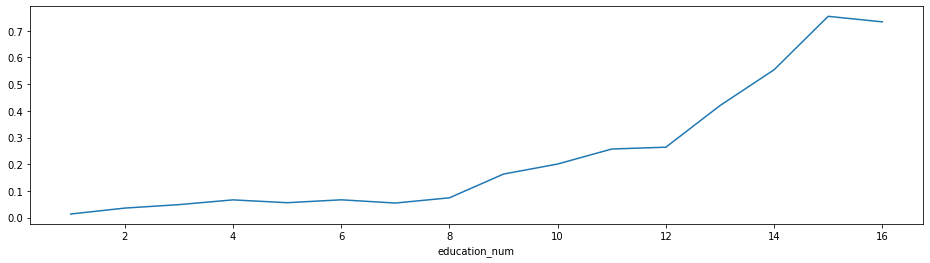

In [7]:
pd.DataFrame(census_df.groupby('education_num')["income_level"].value_counts(normalize=True)
             .unstack('income_level'))[1].plot(figsize = (16, 4))
plt.show()

Na podstawie tego wykresu zdecydowaliśmy na następujące grupowanie wartości.

In [8]:
edu_groups = {
    (1, 2, 3, 4, 5, 6, 7, 8): 'Group1',
    (9, 10): 'Group2',
    (11, 12): 'Group3',
    13: 'Group4',
    14: 'Group5',
    (15, 16): 'Group6'
}

census_df['education_num'] = census_df['education_num'].replace(edu_groups)

### Skorelowane kolumny

W drugim kamieniu milowym zgrupowaliśmy podobne wartości w kolumnach 'marital_status' oraz 'relationship' (ze względu na bardzo podobny procent osób zarabiający ponad 50 tys. dolarów), a następnie pokazaliśmy dużą korelację między tymi kolumnami. Ponownie usuwamy kolumnę 'marital_status', a w drugiej wprowadzamy małe grupowanie.

In [9]:
census_df = census_df.drop(columns = "marital_status")
census_df = census_df.replace({'relationship': {'Wife': 'Married', 'Husband': 'Married'}})

### Grupowanie kolumny 

W przypadku kolumny occupation także dodaliśmy małe grupowanie biorąc pod uwagę wykresy z EDA. Klasa Armed-Forces jest wyjątkowo mało liczna, a klasa Priv-house-serv tylko nieco liczniejsza, ma dodatkowo podobny do Other-service rozkład; grupujemy do Other-service.

In [10]:
census_df = census_df.replace(
    {'occupation': {'Priv-house-serv': 'Other-service', 'Armed-Forces': 'Other-service'}}
)

### Praca z capital gain/loss

W przypadku tych kolumn postanowiliśmy zastąpić je jedną - różnicą gain i loss

In [11]:
census_df["capital_diff"] = census_df["capital_gain"] - census_df["capital_loss"]
census_df = census_df.drop(columns = ["capital_gain", "capital_loss"])

## Encoding

### TargetEncoding dla Native_country

W przypadku kolumny Native_country mamy zbyt dużo wartości, aby stosować OneHotEncoding i uznaliśmy, że w tym przypadku lepiej sprawdzi się TargetEncoding.

In [12]:
target_encoder = ce.TargetEncoder(cols = ['native_country'])
census_df = target_encoder.fit_transform(census_df, census_df['income_level'])

### OnehotEncoding

Dla kolumn o niedużej ilości wartości postanowiliśmy zastosować OneHotEncoding.

In [13]:
columns = ['occupation', 'relationship', 'race', 'workclass', 'education_num']
onehot_encoder = ce.OneHotEncoder(cols = columns)
census_df = onehot_encoder.fit_transform(census_df, census_df['income_level'])

### Przeskalowanie wartości

Dla ulepszenia modelu postanowiliśmy skorzystać z MinMaxScaler.

In [14]:
mms = MinMaxScaler()

census_df[['capital_diff', 'hours_per_week', 'age']] = mms.fit_transform(
    census_df[['capital_diff', 'hours_per_week', 'age']]
)

## Modelowanie

Przy okazji kamienia milowego 2 stworzyliśmy podstawowe modele, tym razem w tym celu użyjemy strojenia hiperparametrów oraz różnych ocen jakości.

### Podział danych na zbiór treningowy i testowy

In [15]:
y = np.array(census_df['income_level'])
X = census_df.drop(['income_level'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Decision Tree

Postanowiliśmy hiperparametryzować jedynie max_depth, min_samples_split, min_samples_leaf. Wcześniej zauważyliśmy, że dla splitter, criterion oraz max_features ustawienia domyślne osiągały lepsze wyniki i z tego powodu nie było sensu ich hiperparametryzować.

In [16]:
from sklearn.tree import DecisionTreeClassifier
param_grid_tree = {
    'max_depth': [9, 10, 11, 12, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [4, 6, 8],
    #'splitter': ["best", "random"],
    #'criterion': ["gini", "entropy"],
    #'max_features': ["auto", None]
}

dt = DecisionTreeClassifier(random_state = 42)
dt_grid = GridSearchCV(dt, param_grid_tree, cv = 2)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [9, 10, 11, 12, None],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [2, 4, 6, 8]})

In [17]:
df_tr = pd.DataFrame(dt_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(df_tr.head(15))

,params,mean_test_score
0,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 6}",0.851895
1,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 4}",0.851895
2,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2}",0.851895
3,"{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 8}",0.851895
4,"{'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 8}",0.851701
5,"{'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 6}",0.851701
6,"{'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 4}",0.851701
7,"{'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 2}",0.851701
8,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 6}",0.851674
9,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 4}",0.851674


Decydującymy czynnikami było max_depth jednocześnie z min_samples_leaf. Min_samples_split w ogóle nie zmieniał wyniku.

Liczymy dodatkowo accuracy, f1, precision, recall, roc_auc i przypisujemy do zmiennej, aby później stworzyć boxploty porównujące nasze modele.

In [18]:
dt_metrics = cross_validate(dt_grid.best_estimator_, X_train, y_train, 
                            scoring = ['accuracy', 'f1',"precision", "recall", "roc_auc"],
                            cv = 6)

### 2. KNeighbors

W przypadku KNeighbors hiperparametryzujemy jedynie n_neighbors oraz p.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
param_grid_KNeighbors = {
    'n_neighbors':[11, 13, 15, 17, 19],
    'p': [1, 2]
    #'weights': ["uniform", "distance"]
}

kn = KNeighborsClassifier()
kn_grid = GridSearchCV(kn, param_grid_KNeighbors, cv = 3)
kn_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [11, 13, 15, 17, 19], 'p': [1, 2]})

In [20]:
kn_df = pd.DataFrame(kn_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(kn_df.head(15))

,params,mean_test_score
0,"{'n_neighbors': 19, 'p': 1}",0.831440
1,"{'n_neighbors': 19, 'p': 2}",0.831053
2,"{'n_neighbors': 17, 'p': 2}",0.830749
3,"{'n_neighbors': 15, 'p': 2}",0.830749
4,"{'n_neighbors': 15, 'p': 1}",0.830611
5,"{'n_neighbors': 17, 'p': 1}",0.830196
6,"{'n_neighbors': 11, 'p': 1}",0.829698
7,"{'n_neighbors': 13, 'p': 1}",0.829533
8,"{'n_neighbors': 11, 'p': 2}",0.828814
9,"{'n_neighbors': 13, 'p': 2}",0.828731


Tworzymy crossvalidation analogicznie jak poprzednio.

In [21]:
kn_metrics = cross_validate(kn_grid.best_estimator_, X_train, y_train,
                            scoring = ['accuracy', 'f1',"precision", "recall", "roc_auc"],
                            cv = 6)

### Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
param_grid_lr = {
    'tol': [1e-4, 1e-3, 1e-5, 3e-4],
    'C': [1, 1.5, 2, 2.5],
    'solver': ['lbfgs', 'sag']
    #'penalty': ["l1", "l2"],
    #'class_weight': ['balanced', None],
}

lr = LogisticRegression(random_state = 42)
lr_grid = GridSearchCV(lr, param_grid_lr, cv = 4)
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1, 1.5, 2, 2.5], 'solver': ['lbfgs', 'sag'],
                         'tol': [0.0001, 0.001, 1e-05, 0.0003]})

In [23]:
lr_df = pd.DataFrame(lr_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(lr_df.head(15))

,params,mean_test_score
0,"{'C': 2, 'solver': 'sag', 'tol': 0.001}",0.839649
1,"{'C': 2, 'solver': 'sag', 'tol': 0.0003}",0.839567
2,"{'C': 2, 'solver': 'sag', 'tol': 1e-05}",0.839539
3,"{'C': 2.5, 'solver': 'sag', 'tol': 0.001}",0.839539
4,"{'C': 2, 'solver': 'sag', 'tol': 0.0001}",0.839484
5,"{'C': 2, 'solver': 'lbfgs', 'tol': 0.0001}",0.839456
6,"{'C': 2, 'solver': 'lbfgs', 'tol': 0.001}",0.839456
7,"{'C': 2, 'solver': 'lbfgs', 'tol': 0.0003}",0.839456
8,"{'C': 2, 'solver': 'lbfgs', 'tol': 1e-05}",0.839456
9,"{'C': 2.5, 'solver': 'sag', 'tol': 1e-05}",0.839456


In [24]:
lr_metrics = cross_validate(lr_grid.best_estimator_, X_train, y_train,
                            scoring = ['accuracy', 'f1',"precision", "recall", "roc_auc"],
                            cv = 6)

### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
param_grid_forest = {
    'max_depth': [13, 15, 17, 20, None],
    'criterion': ["gini", "entropy"],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4, 6]
    #'splitter': ["best", "random"],
    #'max_features': ["auto", None] 
}

rf = RandomForestClassifier(n_estimators = 150, random_state = 42)
rf_grid = GridSearchCV(rf, param_grid_forest, cv = 2)
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestClassifier(n_estimators=150,
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [13, 15, 17, 20, None],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 4, 6]})

In [26]:
rf_df = pd.DataFrame(rf_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(rf_df.head(50))

,params,mean_test_score
0,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 4}",0.858501
1,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 6}",0.858501
2,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}",0.858501
3,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 6}",0.858197
4,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 4}",0.858197
5,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 2}",0.858197
6,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 6}",0.858004
7,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 4}",0.858004
8,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 2}",0.858004
9,"{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}",0.857368


In [27]:
rf_metrics = cross_validate(rf_grid.best_estimator_, X_train, y_train,
                            scoring = ['accuracy', 'f1',"precision", "recall", "roc_auc"],
                            cv = 6)

### Ada Boost

In [28]:
from sklearn.ensemble import AdaBoostClassifier
param_grid_ada = {
    'n_estimators': [40, 50, 60, 70, 150],
    'learning_rate': [0.5, 1, 1.5, 2]
}

ada = AdaBoostClassifier(random_state = 42)
ada_grid = GridSearchCV(ada, param_grid_ada, cv = 3)
ada_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.5, 1, 1.5, 2],
                         'n_estimators': [40, 50, 60, 70, 150]})

In [29]:
ada_df = pd.DataFrame(ada_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(ada_df.head(15))

,params,mean_test_score
0,"{'learning_rate': 1.5, 'n_estimators': 150}",0.862288
1,"{'learning_rate': 1, 'n_estimators': 150}",0.861431
2,"{'learning_rate': 1.5, 'n_estimators': 60}",0.859856
3,"{'learning_rate': 1.5, 'n_estimators': 70}",0.859137
4,"{'learning_rate': 1, 'n_estimators': 70}",0.858501
5,"{'learning_rate': 0.5, 'n_estimators': 150}",0.858225
6,"{'learning_rate': 1, 'n_estimators': 60}",0.857423
7,"{'learning_rate': 1.5, 'n_estimators': 50}",0.856953
8,"{'learning_rate': 1, 'n_estimators': 50}",0.855903
9,"{'learning_rate': 1.5, 'n_estimators': 40}",0.855627


In [30]:
ada_metrics = cross_validate(ada_grid.best_estimator_, X_train, y_train,
                             scoring = ['accuracy', 'f1',"precision", "recall", "roc_auc"],
                             cv = 6)

### XGBoost

In [31]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'max_depth': [8, 10, 12, 14, 16, 18, None],
    'learning_rate': [0.03, 0.1, 0.3, 0.001],
    #'splitter': ["best", "random"],
    #'max_features': ["auto", None]
}

xgb = XGBClassifier(random_state = 42)
xgb_grid = GridSearchCV(xgb, param_grid_xgb, cv = 2)
xgb_grid.fit(X_train, y_train)

[12:51:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, v

In [32]:
xgb_df = pd.DataFrame(xgb_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(xgb_df.head(15))

,params,mean_test_score
0,"{'learning_rate': 0.1, 'max_depth': None}",0.866352
1,"{'learning_rate': 0.1, 'max_depth': 8}",0.865522
2,"{'learning_rate': 0.3, 'max_depth': None}",0.865467
3,"{'learning_rate': 0.1, 'max_depth': 10}",0.864306
4,"{'learning_rate': 0.1, 'max_depth': 12}",0.862620
5,"{'learning_rate': 0.3, 'max_depth': 8}",0.861652
6,"{'learning_rate': 0.03, 'max_depth': 10}",0.861569
7,"{'learning_rate': 0.03, 'max_depth': 12}",0.861404
8,"{'learning_rate': 0.03, 'max_depth': 8}",0.860491
9,"{'learning_rate': 0.1, 'max_depth': 14}",0.860077


In [33]:
xgb_metrics = cross_validate(xgb_grid.best_estimator_, X_train, y_train,
                             scoring = ['accuracy', 'f1',"precision", "recall", "roc_auc"],
                             cv = 6)

[12:53:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Bagging

In [34]:
from sklearn.ensemble import BaggingClassifier
model_bagg = BaggingClassifier(base_estimator=xgb_grid.best_estimator_,
                        n_estimators=15, random_state=42)
model_bagg.fit(X_train, y_train)

[12:53:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

BaggingClassifier(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                               colsample_bylevel=1,
                                               colsample_bynode=1,
                                               colsample_bytree=1, gamma=0,
                                               gpu_id=-1,
                                               importance_type='gain',
                                               interaction_constraints='',
                                               learning_rate=0.1,
                                               max_delta_step=0, max_depth=6,
                                               min_child_weight=1, missing=nan,
                                               monotone_constraints='()',
                                               n_estimators=100, n_jobs=12,
                                               num_parallel_tree=1,
                                               random_state=42

In [35]:
bagging_metrics = cross_validate(model_bagg, X_train, y_train,
                                 scoring = ['accuracy', 'f1',"precision", "recall", "roc_auc"], 
                                 cv = 6)

[12:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:53:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

### Voting


Przy dobieraniu estymatorów kierowaliśmy się uzyskanymi wcześniej miarami jakości innych modeli. Wybraliśmy 5 najlepszych.

In [36]:
from sklearn.ensemble import VotingClassifier

param_voting = {
    'voting':['hard','soft']
}

estimators=[('XGB', xgb_grid.best_estimator_), ('Bagging ', model_bagg),
            ('AdaBoost', ada_grid.best_estimator_), ("RandomForest", rf_grid.best_estimator_),
            ("DecisionTree", dt_grid.best_estimator_)]

voting = VotingClassifier(estimators=estimators)
voting_grid = GridSearchCV(voting, param_voting, cv = 2)

voting_grid.fit(X_train, y_train)

[12:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=2,
             estimator=VotingClassifier(estimators=[('XGB',
                                                     XGBClassifier(base_score=0.5,
                                                                   booster='gbtree',
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   gamma=0,
                                                                   gpu_id=-1,
                                                                   importance_type='gain',
                                                                   interaction_constraints='',
                                                                   learning_rate=0.1,
                                                                 

In [37]:
voting_df = pd.DataFrame(voting_grid.cv_results_)[['params', 'mean_test_score']]\
    .sort_values('mean_test_score', ascending=False).reset_index(drop = True)

with pd.option_context('display.max_colwidth', 400):
    display(voting_df.head(15))

,params,mean_test_score
0,{'voting': 'hard'},0.866130
1,{'voting': 'soft'},0.863339


In [38]:
voting_metrics = cross_validate(voting_grid.best_estimator_, X_train, y_train,
                                scoring = ['accuracy', 'f1',"precision", "recall"],
                                cv = 6)

[12:57:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:57:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [39]:
from sklearn import metrics

def modelMetrics(clf, X_val, y_val):
    #wykresy
    fig, [ax_roc, ax_cfm, ax_det] = plt.subplots(1, 3, figsize=(20, 5))
    metrics.plot_roc_curve(clf, X_val, y_val, ax=ax_roc)
    metrics.plot_confusion_matrix(clf, X_val, y_val, ax=ax_cfm, normalize="true")
    metrics.plot_det_curve(clf, X_val, y_val, ax=ax_det)
    ax_roc.set_title('ROC curve')
    ax_cfm.set_title('Confussion matrix')
    ax_det.set_title('DET curve')
    ax_roc.grid(linestyle='--')
    ax_det.grid(linestyle='--')
    plt.show()
    #liczby
    print("accuracy:", metrics.accuracy_score(y_val, clf.predict(X_val)))
    print("recall:", metrics.recall_score(y_val, clf.predict(X_val)))
    print("precision:", metrics.precision_score(y_val, clf.predict(X_val)))
    print("f1:", metrics.f1_score(y_val, clf.predict(X_val)))
    print("AUC ROC:", metrics.roc_auc_score(y_val, clf.predict(X_val)))

# Metryki

In [40]:
voting_metrics["name"] = "Voting"
bagging_metrics["name"] = "Bagging"
xgb_metrics["name"] = "XGBClassifier"
ada_metrics["name"] = "AdaBoost"
rf_metrics["name"] = "RandomForest"
lr_metrics["name"] = "Logistic\nRegression"
kn_metrics["name"] = "KNeighbors"
dt_metrics["name"] = "DecisionTree"

In [41]:
def plot_boxplot(results, metric, colour_to_fill):
    results_list = []
    clf_names = []
    for result in results:
        results_list.append(result[metric])
        clf_names.append(result["name"])   
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize =(10, 7))
        ax = fig.add_axes([0, 0, 1, 1])
        bp = ax.boxplot(results_list,
                       medianprops=dict(color="red",linewidth=2), patch_artist=True,
            # Set facecolor and surrounding line to red
            boxprops=dict(facecolor=colour_to_fill))
        ax.set_xticklabels(clf_names)
        plt.title(metric[5:])
        plt.grid(b=None, axis='x')
    plt.show()

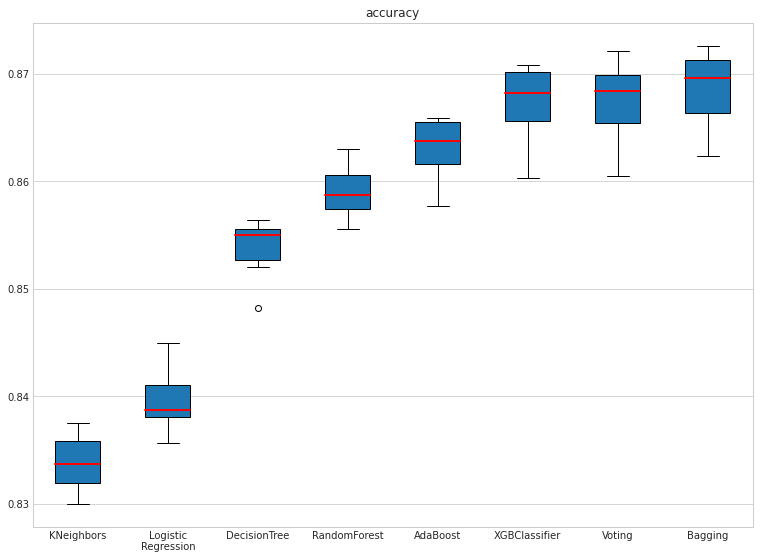

In [42]:
plot_boxplot([kn_metrics, lr_metrics, dt_metrics, rf_metrics, ada_metrics,
              xgb_metrics, voting_metrics, bagging_metrics],
             "test_accuracy", "tab:blue")

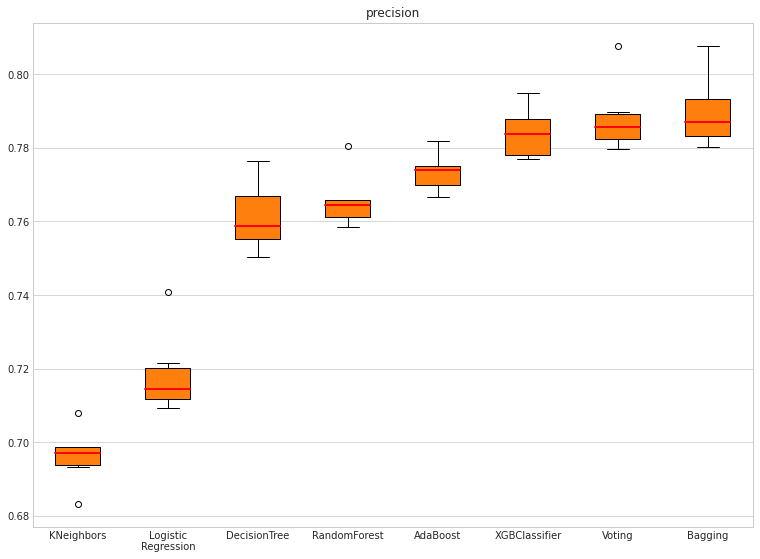

In [43]:
plot_boxplot([kn_metrics, lr_metrics, dt_metrics, rf_metrics, ada_metrics,
              xgb_metrics, voting_metrics, bagging_metrics],
             "test_precision", "tab:orange")

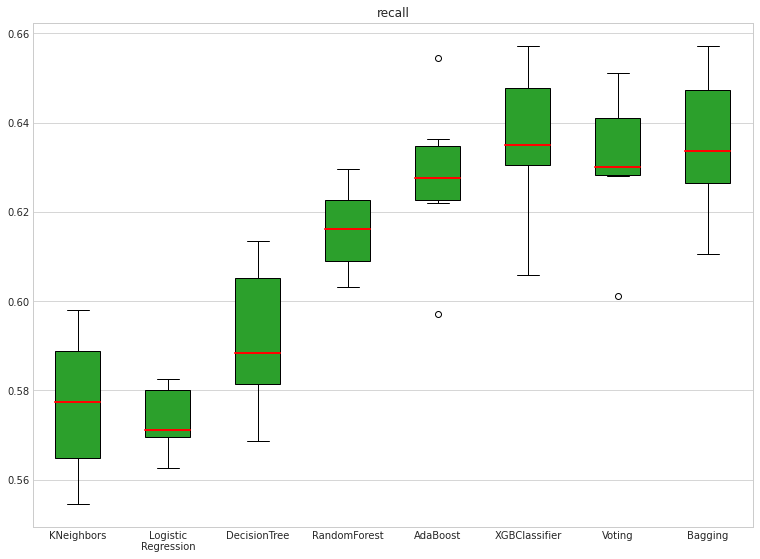

In [44]:
plot_boxplot([kn_metrics, lr_metrics, dt_metrics, rf_metrics, ada_metrics,
              xgb_metrics, voting_metrics, bagging_metrics],
             "test_recall", "tab:green")

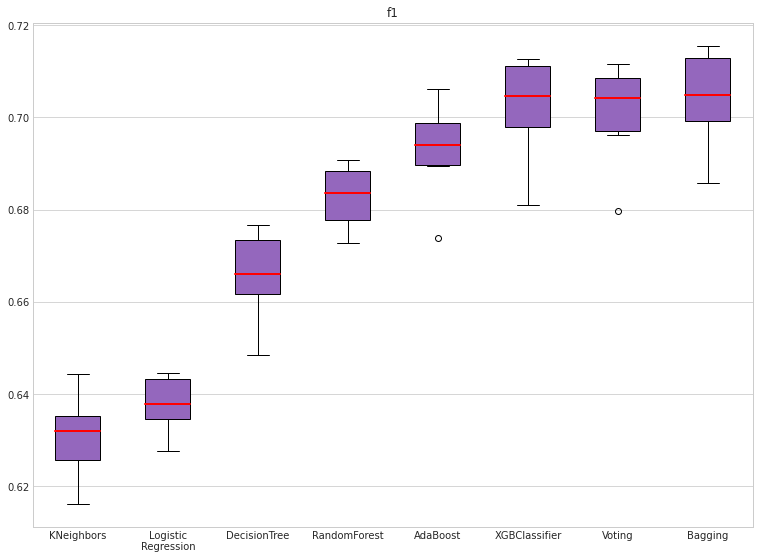

In [45]:
plot_boxplot([ kn_metrics,  lr_metrics, dt_metrics, rf_metrics, ada_metrics, xgb_metrics,
              voting_metrics, bagging_metrics],
             "test_f1", "tab:purple")

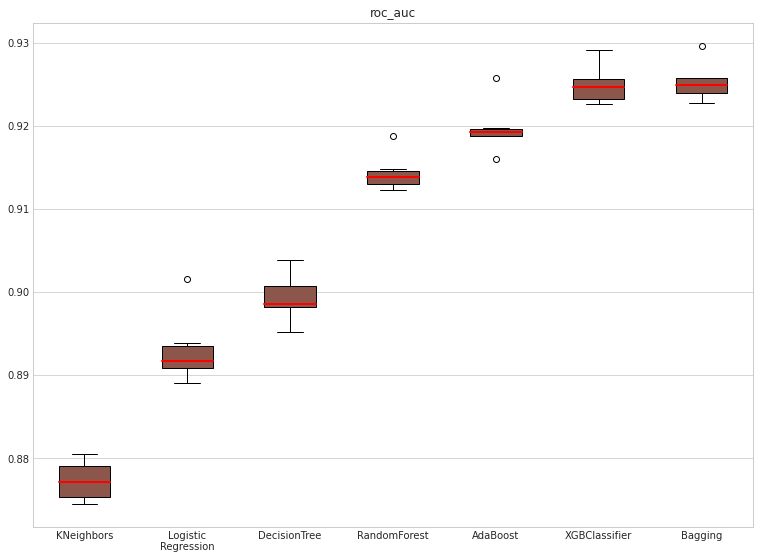

In [46]:
plot_boxplot([ kn_metrics,  lr_metrics, dt_metrics, rf_metrics, ada_metrics,
              xgb_metrics, bagging_metrics],
             'test_roc_auc', "tab:brown")

KNeighbors pomimo długiego uczenia, dawało najgorsze wyniki.
DecisionTree we wstępnym modelowaniu osiągało jedne z najlepszych wyników, teraz zostało prześcignięte.
Voting radził sobie gorzej niż Bagging, co nas zdziwiło.

Metryki, których wartości zostały wcześniej wyliczone przez crossvalidację, a następnie zwizualizowane wykresami zawierającymi boxploty, wskazały nam jednoznacznie 3 modele w kolejności od najlepszego - Bagging, Voting, XGBoost.
Przyjrzymy się więc im w szczególności.

## Wybór modelu

Używane przez nas metryki jednoznacznie wskazały najlepsze modele. Przyjrzyjmy się więc kolejnym metrykom, by wyłonić najlepszy model.

### Bagging

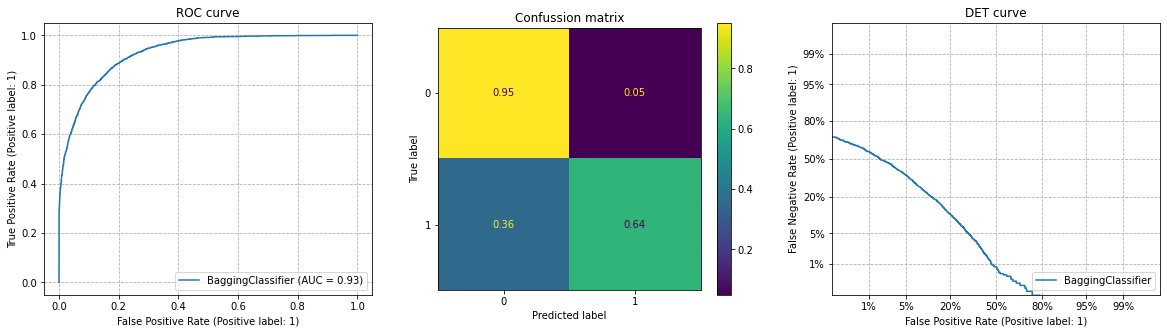

accuracy: 0.8713101160862355
recall: 0.6404347826086957
precision: 0.8138121546961326
f1: 0.7167883211678832
AUC ROC: 0.795235923550456


In [47]:
modelMetrics(model_bagg, X_test, y_test)

### Voting

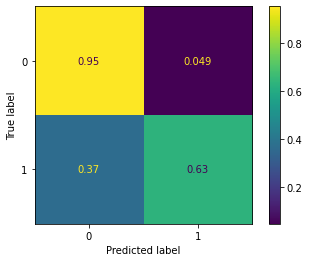

accuracy: 0.8693200663349917
recall: 0.6304347826086957
precision: 0.813692480359147
f1: 0.7104360607545323


In [48]:
clf = voting_grid.best_estimator_
X_val = X_test
y_val = y_test

metrics.plot_confusion_matrix(clf, X_val, y_val, normalize="true")
plt.show()

print("accuracy:", metrics.accuracy_score(y_val, clf.predict(X_val)))
print("recall:", metrics.recall_score(y_val, clf.predict(X_val)))
print("precision:", metrics.precision_score(y_val, clf.predict(X_val)))
print("f1:", metrics.f1_score(y_val, clf.predict(X_val)))

Z wykresów dla votingClassifier stworzyliśmy tylko ConfusionMatrix dlatego, że nasz model nie jest w stanie określać prawdopodobieństwa pewności klasyfikacji.

### XGB

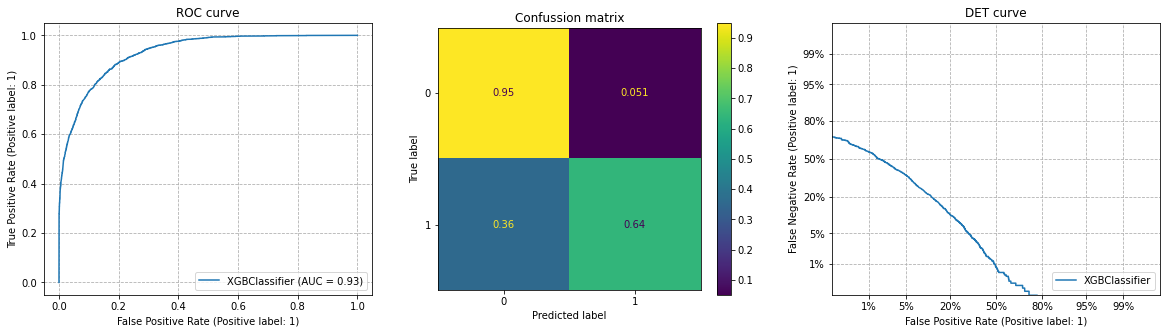

accuracy: 0.8713101160862355
recall: 0.6434782608695652
precision: 0.8114035087719298
f1: 0.7177497575169738
AUC ROC: 0.7962387597898604


In [49]:
modelMetrics(xgb_grid.best_estimator_, X_test, y_test)

XGB oraz Bagging osiągały niemalże identyczne wyniki na wcześniej określonym zbiorze testowym. W związku z tym, bardzo ciężko wybrać najlepszy model, postanowiliśmy zatem wybrać kierując się poprzednimi kroswalidacjami. Bagging okazał się najlepszy.